In [111]:
import psycopg2, psycopg2.extras, psycopg2.pool, pickle, json, matplotlib, sys, time
from multiprocessing import Pool, Manager
from collections import OrderedDict
import matplotlib.pyplot as plt; import numpy as np; import pandas as pd
import seaborn as sns; from sqlalchemy import create_engine
from IPython import display
%matplotlib inline

# When are users most active on the tile... and how experienced are they?

In [2]:
study_tiles = json.loads(open('study_tiles_with_compare_tiles.json','r').read())
print("Found {0} tiles.".format(len(study_tiles)))

Found 9 tiles.


In [3]:
years = [2005+i for i in range(12)]
years

[2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

In [4]:
# Create connections for panda queries
pd_engines = []
pd_connections = []
for idx, year in enumerate(years):
    pd_engines.append( create_engine("postgresql://anderstj@127.0.0.1:5432/world-{0}".format(year)) )
    pd_connections.append(pd_engines[idx].connect())

def reset(pd_connections):
    new_cons = []
    for idx, con in enumerate(pd_connections):
        con.close()
        new_cons.append(pd_engines[idx].connect())
    return new_cons

# pd_connections = reset(pd_connections)

In [5]:
def get_all_users_who_edited_tile(tile):
    users_on_tile = []
    for idx, year in enumerate(years):
        print(year, end=" . ")
        query_string = """SELECT distinct(uid) FROM per_tile WHERE quadkey = '{0}'""".format(tile['quad'])
        year_df = pd.read_sql_query(query_string,con=pd_connections[idx])
        users_on_tile = np.append(users_on_tile,year_df.uid.values)
    return np.unique(users_on_tile)

def annual_worker_function(args):
    """
    Input: List of users and a year of choice
    Returns: Dictionary, keyed by UID of all a user's edits for given year
    """
    (user_list, year_idx, q) = args
    dict_to_return = {}

    #Query for 50 users at a time
    for sub_list in [user_list[i:i + 50] for i in range(0, len(user_list), 50)]:
    
        query_string = """SELECT per_tile.quadkey,
                                 per_tile.year,
                                 per_tile.uid,
                                 per_tile.buildings,
                                 per_tile.road_km,
                                 per_tile.amenities,
                                 per_tile.edits,
                                 array_length(per_tile.active_days,1) AS "num_days",
                                 user_stats.uid AS "user_stats_uid",
                                 user_stats.name AS "user_name",
                                 user_stats.year AS "total_year",
                                 user_stats.buildings AS "total_buildings",
                                 user_stats.road_km AS "total_road_km",
                                 user_stats.amenities AS "total_amenities",
                                 user_stats.edits AS "total_edits",
                                 array_length(user_stats.active_days,1) AS "total_active_days"
                          FROM per_tile, user_stats 
                          WHERE per_tile.uid = user_stats.uid AND 
                                per_tile.uid = ANY(ARRAY[%s])"""%(", ".join([str(i) for i in sub_list]))
        df = pd.read_sql_query(query_string, con=pd_connections[year_idx])
        
#         with open('tmp.log','w') as oFile:
#             oFile.write(df.to_csv())

        for uid in df['uid'].unique():
            dict_to_return[uid] = df[:][df.uid == uid]
            q.put(1)
    return dict_to_return

def build_user_distributions(uids):
    """
        Given a list of user ids, spin up 12 processes (1 per year) to get back dictionaries, keyed by UID
            of all a user's tiles for that year; then combine all of the years.
        
        Returns: A dictionary: { UID : DataFrame of all a user's edits (across all years) }
    """
    m = Manager()
    q = m.Queue()
    p = Pool(12)
    args = [ (uids, year_idx, q) for year_idx in range(12)]
    
    max_val = round(len(uids)*len(args)*0.4)

    result = p.map_async(annual_worker_function, args)
    
    while True:
        if result.ready():
            break
        else:
            size = q.qsize()
            sys.stderr.write("\r "+str(size)+ "/ ~ " + str(max_val))
            time.sleep(1)
    
    aggregated = {}
    
    for year_data in result.get():
        for uid, data in year_data.items():
            if uid in aggregated:
                aggregated[uid]['df'] = pd.concat([aggregated[uid]['df'], data], ignore_index=True)
            else:
                #This is the first we see this user
                aggregated[uid] = {'df':data}
    p.close()
    return aggregated

### With each user's dataframe, compute user focus stats

In [6]:
def calculate_user_focus(args):
    """
    
    """
    df, q = args
    agged_quad = df.groupby('quadkey').aggregate({'buildings':sum,
                                                 'road_km'  :sum,
                                                 'edits'    :sum,
                                                 'amenities':sum,
                                                 'num_days' :sum})
    
    agged_quad['percent_user_road_km']   = agged_quad.road_km   / agged_quad.road_km.sum()*100
    agged_quad['percent_user_buildings'] = agged_quad.buildings / agged_quad.buildings.sum()*100
    agged_quad['percent_user_amenities'] = agged_quad.amenities / agged_quad.amenities.sum()*100
    agged_quad['percent_user_edits']     = agged_quad.edits     / agged_quad.edits.sum()*100
    

    annual_stats = pd.DataFrame()
    for year in df.total_year.unique():
        this_year = df[['uid','user_name','year','total_buildings','total_road_km','total_amenities','total_edits','total_active_days']].query('year=={0}'.format(year)).head(1)
        annual_stats = pd.concat( [annual_stats, this_year], ignore_index=True)
    
    if(q):
        q.put(1)
    return (agged_quad, annual_stats)

def process_dictionary_of_users(user_dict):
    """
    
    """
    sorted_users = sorted(list(user_dict.keys()))
    
    m = Manager()
    q = m.Queue()
    p = Pool(24)
    
    args = [ (user_dict[uid]['df'], q) for uid in sorted_users]
    result = p.map_async(calculate_user_focus, args)
    
    while True:
        if result.ready():
            break
        else:
            sys.stderr.write("\r "+str(q.qsize())+ "/" + str(len(sorted_users)))
            time.sleep(0.5)

    res = result.get()
    for idx, user in enumerate(sorted_users):
        user_dict[user]['tiles'] = res[idx][0]
        user_dict[user]['annual'] = res[idx][1]
        
    p.close()

In [33]:
def pull_out_study_tile(args):
    """
        For each user, pull out just the quadkey we want; but also tally the annual stuff...
    """
    df, quad, q = args
    
    tile_of_interest = pd.DataFrame(df.query("quadkey=='{0}'".format(quad)))

    if(q):
        q.put(1)
    return tile_of_interest

def process_dictionary_of_users_for_study_tile_stats(user_dict, quad):
    """
    
    """
    sorted_users = sorted(list(user_dict.keys()))
    
    m = Manager()
    q = m.Queue()
    p = Pool(24)
    
    args = [ (user_dict[uid]['df'], quad, q) for uid in sorted_users]
    result = p.map_async(pull_out_study_tile, args)
    
    while True:
        if result.ready():
            break
        else:
            sys.stderr.write("\r "+str(q.qsize())+ "/" + str(len(sorted_users)))
            time.sleep(0.5)

    res = result.get()
    for idx, user in enumerate(sorted_users):
        user_dict[user]['toi'] = res[idx]
        
    p.close()

In [7]:
def build_all_stats_for_tile(current_tile):
    """
    
    """
    current_tile_df = pd.DataFrame()
    for u,data in current_tile['users'].items():
        data['tiles']['uid'] = u
        data['tiles']['total_editing_days_ever'] = data['annual'].total_active_days.sum()
        data['tiles']['total_buildings_ever'] = data['annual'].total_buildings.sum()
        data['tiles']['total_road_km_ever'] = data['annual'].total_road_km.sum()
        data['tiles']['total_amenities_ever'] = data['annual'].total_amenities.sum()
        data['tiles']['total_edits_ever'] = data['annual'].total_edits.sum()
        current_tile_df = pd.concat([current_tile_df, pd.DataFrame(data['tiles'].query("quadkey=='{0}'".format(current_tile['quad'])))],ignore_index=True)

    current_tile_df['percent_tile_road_km']   = current_tile_df.road_km   / current_tile_df.road_km.sum()*100
    current_tile_df['percent_tile_buildings'] = current_tile_df.buildings / current_tile_df.buildings.sum()*100
    current_tile_df['percent_tile_amenities'] = current_tile_df.amenities / current_tile_df.amenities.sum()*100
    current_tile_df['percent_tile_edits']     = current_tile_df.edits     / current_tile_df.edits.sum()*100
    
    return current_tile_df

# Study Tiles: Load data for a specific study tile

In [8]:
for idx, tile in enumerate(study_tiles):
    print(idx, tile['name'])

0 Port Au Prince, Haiti
1 Trisuli Bazar, Nepal
2 Tacloban
3 Kenema, Sierra Leone
4 Monrovia, Liberia
5 Kathmandu, Nepal
6 Heidelberg, Germany
7 London
8 Manhattan, NY


## 1. Get the `user_list`

In [11]:
"""
    First: Set the index for the study tile you want.
"""
study_tile_idx = 0

In [12]:
pd_connections = reset(pd_connections)
study_tiles[study_tile_idx]['user_list'] = get_all_users_who_edited_tile(study_tiles[study_tile_idx])

2005 . 2006 . 2007 . 2008 . 2009 . 2010 . 2011 . 2012 . 2013 . 2014 . 2015 . 2016 . 

In [13]:
print("Found: {0} users".format(len(study_tiles[study_tile_idx]['user_list'])))

Found: 440 users


## 2. Build the User Distributions
If this doesn't run, run the cell 2 above again)

In [14]:
study_tiles[study_tile_idx]['users'] = build_user_distributions(study_tiles[study_tile_idx]['user_list'])

 2194/ ~ 2112

### Check these results

In [15]:
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['df'].head())

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,102322322323,2005,143,0,0.0,0,5,1,143,sxpert,2005,0,0.0,0,1154,5
1,120032111012,2005,143,0,0.0,0,12,1,143,sxpert,2005,0,0.0,0,1154,5
2,120032110311,2005,143,0,0.0,0,10,1,143,sxpert,2005,0,0.0,0,1154,5
3,120032111200,2005,143,0,0.0,0,3,1,143,sxpert,2005,0,0.0,0,1154,5
4,120023332011,2005,143,0,0.0,0,11,1,143,sxpert,2005,0,0.0,0,1154,5


## 3. Get tile focus for each user

In [31]:
process_dictionary_of_users(study_tiles[study_tile_idx]['users'])

 440/440

## 3.5 Pull out per-user-study tile stats

In [55]:
process_dictionary_of_users_for_study_tile_stats(study_tiles[study_tile_idx]['users'], study_tiles[study_tile_idx]['quad'])

 435/440

### Inspect these

In [56]:
# So what's saved from this?
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['tiles'].head())
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['annual'].head())
display.display(study_tiles[study_tile_idx]['users'][study_tiles[study_tile_idx]['user_list'][0]]['toi'].head())

,edits,amenities,num_days,buildings,road_km,percent_user_road_km,percent_user_buildings,percent_user_amenities,percent_user_edits,uid,total_editing_days_ever,total_buildings_ever,total_road_km_ever,total_amenities_ever,total_edits_ever
quadkey,,,,,,,,,,,,,,,
031331301203,2,0,1,0,0.000000,0.000000,0.0,0.000000,0.003337,143,187,2348,1621.42945,187,59937
031333131030,1,0,1,0,0.042327,0.002610,0.0,0.000000,0.001668,143,187,2348,1621.42945,187,59937
031333131032,30,5,1,0,3.370290,0.207859,0.0,2.673797,0.050053,143,187,2348,1621.42945,187,59937
031333131313,1,0,1,0,4.590440,0.283111,0.0,0.000000,0.001668,143,187,2348,1621.42945,187,59937
032211201213,1,0,1,0,0.034253,0.002113,0.0,0.000000,0.001668,143,187,2348,1621.42945,187,59937


,uid,user_name,year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,143,sxpert,2005,0,0.0000,0,1154,5
1,143,sxpert,2006,0,61.1980,5,18406,48
2,143,sxpert,2007,6,811.2400,52,27720,53
3,143,sxpert,2008,18,627.7060,76,5508,31
4,143,sxpert,2009,543,40.1319,31,4334,14


,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
481,032211203001,2010,143,149,2.64401,0,174,2,143,sxpert,2010,257,42.1018,13,975,14


## 4. Who is mapping what: Build Current Tile DF

In [57]:
current_tile_df = build_all_stats_for_tile(study_tiles[study_tile_idx])

In [58]:
current_tile_df.head()

,edits,amenities,num_days,buildings,road_km,percent_user_road_km,percent_user_buildings,percent_user_amenities,percent_user_edits,uid,total_editing_days_ever,total_buildings_ever,total_road_km_ever,total_amenities_ever,total_edits_ever,percent_tile_road_km,percent_tile_buildings,percent_tile_amenities,percent_tile_edits
0,250,1,13,151,3.163200,0.152193,0.455437,0.212314,0.635922,1443840,276,33155,2078.421800,471,39313,0.108544,1.015331,0.013622,0.572253
1,2,0,1,0,0.000000,0.000000,0.000000,0.000000,0.000440,307202,998,7659,128673.043000,6275,454250,0.000000,0.000000,0.000000,0.004578
2,1,0,1,1,0.000000,0.000000,0.123916,0.000000,0.018836,15363,185,807,516.256897,228,5309,0.000000,0.006724,0.000000,0.002289
3,2,0,2,0,0.188931,0.001451,0.000000,0.000000,0.016462,663559,361,1313,13020.981900,115,12149,0.006483,0.000000,0.000000,0.004578
4,1,0,1,0,0.186651,0.000669,0.000000,0.000000,0.000429,196617,922,4170,27907.690000,1116,233097,0.006405,0.000000,0.000000,0.002289


Processed Study tiles now have the following attributes: 

- **name**: Name of Region
- **user_list**: List of UIDs of users who have edited on this tile
- **users**: Dictionary, keyed by UID
  - `uid`:
    - **df**: Full dataframe of all edits on all tiles by this user
    - **tiles**: DataFrame of unique tiles, summed over all years
    - **annual**: DataFrame of Editing Aggregates over all tiles, per year
    - **toi**: DataFrame of just edits to the study tile per user

# Begin Analysis

In [60]:
print("Current Study Tile: {0}".format(study_tiles[study_tile_idx]['name']))
print("\tUsers: {0}".format(len(study_tiles[study_tile_idx]['user_list'])))
print("Current_tile_df size: {0} (Should match the user count)".format(len(current_tile_df)))

Current Study Tile: Port Au Prince, Haiti
	Users: 440
Current_tile_df size: 440 (Should match the user count)


In [61]:
overtime_df = pd.DataFrame()
for uid, data in study_tiles[study_tile_idx]['users'].items():

    safe_df = pd.DataFrame(data['annual'].sort_values(by='year'))
    safe_df['active_days_to_date'] = safe_df.total_active_days.cumsum()

    new_df = data['toi'].merge(safe_df[['active_days_to_date','year']], on='year')

    overtime_df = pd.concat([overtime_df, new_df],ignore_index=True)

overtime_df.head()

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days,active_days_to_date
0,032211203001,2015,1443840,151,3.163200,1,250,13,1443840,dkunce,2015,14542,1101.4800,162,17281,111,210
1,032211203001,2011,307202,0,0.000000,0,2,1,307202,alester,2011,980,1159.9800,1406,10978,117,172
2,032211203001,2010,15363,1,0.000000,0,1,1,15363,TheChief,2010,23,25.6589,40,248,20,124
3,032211203001,2013,663559,0,0.188931,0,2,2,663559,geochrome,2013,779,4047.8700,32,4208,122,250
4,032211203001,2014,196617,0,0.186651,0,1,1,196617,venerdi,2014,144,3283.1900,328,14038,72,723


In [85]:
overtime_df.query('active_days_to_date>10').query('year==2010').head()

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days,active_days_to_date
2,032211203001,2010,15363,1,0.000000,0,1,1,15363,TheChief,2010,23,25.6589,40,248,20,124
5,032211203001,2010,178186,0,0.008948,0,1,1,178186,mdk,2010,11912,3895.9500,1424,38220,222,251
8,032211203001,2010,102411,11,3.532960,0,26,4,102411,Jeff Ollie,2010,2082,42597.9000,1358,72766,190,313
17,032211203001,2010,36894,0,0.412340,0,7,4,36894,rab,2010,2094,5006.2000,40,29953,187,513
24,032211203001,2010,219591,0,0.343480,0,1,1,219591,JP CASSOU,2010,82059,1626.4100,658,90845,92,92


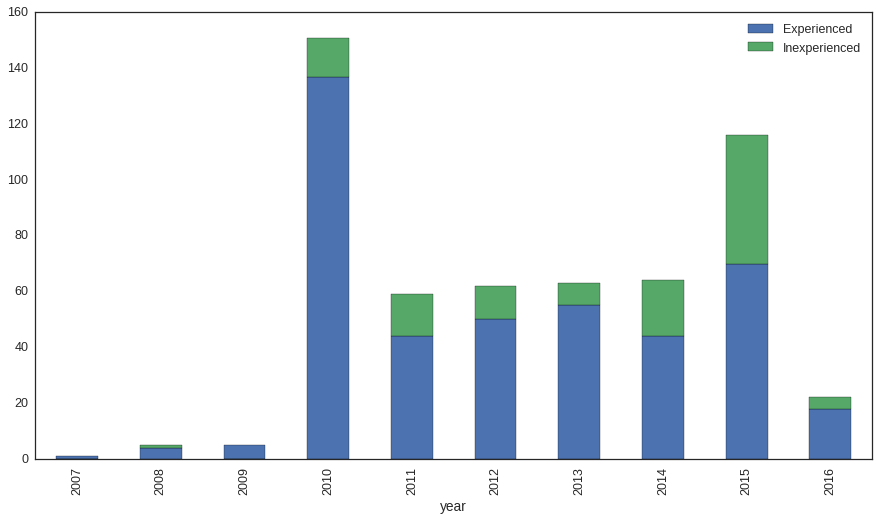

In [108]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,8), facecolor='w', edgecolor='k')

threshold = 7

gt_10 = overtime_df.query("active_days_to_date>={0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})
lt_10 = overtime_df.query("active_days_to_date<{0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})

gt_10.columns = ['Experienced']
lt_10.columns = ['Inexperienced']

gt_10.join(lt_10).plot(ax=axs,kind='bar',stacked=True)

<hr>
# Run Tile-by-Tile Comparisons
For each study tile, we have _comparable_ tiles, these are the tiles of most interest, because the difference in patterns between these tiles and our study tiles is what makes the analysis.

## 1. Get a _comparable_ tile

In [ ]:
# '132232231103' is Singapore!

In [86]:
if 'compare_tiles' in study_tiles[study_tile_idx]:
    print("Comparable Tiles for {0}: ".format(study_tiles[study_tile_idx]['name']))
    for idx, compare in enumerate(study_tiles[study_tile_idx]['compare_tiles']):
        print("\t{0}, '{1}'".format(idx, compare['quad']))

Comparable Tiles for Port Au Prince, Haiti: 
	0, '120213000002'
	1, '120213101133'
	2, '031313131101'
	3, '120212032230'
	4, '120213302032'
	5, '120213231000'
	6, '120203231331'
	7, '120221101003'
	8, '120221100133'
	9, '120221130301'
	10, '120221033031'
	11, '120221122003'
	12, '120221122002'
	13, '120221033332'
	14, '120221202330'
	15, '120230320101'
	16, '120223110301'
	17, '122101130101'
	18, '033110210131'
	19, '122000322212'
	20, '033333010032'
	21, '132232231103'
	22, '021333011030'
	23, '032211203002'
	24, '032211203003'


In [100]:
#Which tile to compare? (from within the comparable study tiles)
compare_tile_idx=21

## 2. Get Users

In [89]:
pd_connections = reset(pd_connections)
pd_connections = reset(pd_connections)
study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'] = get_all_users_who_edited_tile(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx])

2005 . 2006 . 2007 . 2008 . 2009 . 2010 . 2011 . 2012 . 2013 . 2014 . 2015 . 2016 . 

## 3. Build actual user distribution (may take a few minutes)
If it fails, run the above cell again (probably twice)

In [90]:
study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'] = build_user_distributions(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'])

 2011/ ~ 2645

In [91]:
# Check these results?
display.display(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'][study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list'][0]]['df'].head())

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,031311301000,2006,308,0,0.0,0,149,1,308,MichaelCollinson,2006,0,1546.1,1138,67868,81
1,031311301002,2006,308,0,0.0,0,7,1,308,MichaelCollinson,2006,0,1546.1,1138,67868,81
2,031311301032,2006,308,0,0.0,0,1,1,308,MichaelCollinson,2006,0,1546.1,1138,67868,81
3,031311301210,2006,308,0,0.0,0,59,1,308,MichaelCollinson,2006,0,1546.1,1138,67868,81
4,031311301213,2006,308,0,0.0,0,14,1,308,MichaelCollinson,2006,0,1546.1,1138,67868,81


## 3.5 Pull out per-user-study tile stats

In [96]:
process_dictionary_of_users_for_study_tile_stats(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'], study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['quad'])

 450/551

## 4. Now process user focus for compare tiles

In [101]:
process_dictionary_of_users(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'])
display.display(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'][study_tiles[study_tile_idx]['compare_tiles'][idx]['user_list'][0]]['tiles'].head())
display.display(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'][study_tiles[study_tile_idx]['compare_tiles'][idx]['user_list'][0]]['annual'].head())

 551/551

,edits,amenities,num_days,buildings,road_km,percent_user_road_km,percent_user_buildings,percent_user_amenities,percent_user_edits
quadkey,,,,,,,,,
002331131311,3,0,1,0,0.0,0.0,0.0,0.0,0.000406
003132021330,1,0,1,0,0.0,0.0,0.0,0.0,0.000135
003220020200,3,0,1,0,0.0,0.0,0.0,0.0,0.000406
003331131311,1,0,1,0,0.0,0.0,0.0,0.0,0.000135
010123301120,1,0,1,0,0.0,0.0,0.0,0.0,0.000135


,uid,user_name,year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days
0,308,MichaelCollinson,2006,0,1546.10,1138,67868,81
1,308,MichaelCollinson,2007,574,6472.24,1650,317861,249
2,308,MichaelCollinson,2008,1784,25959.30,906,65649,158
3,308,MichaelCollinson,2009,4861,25068.20,949,49069,142
4,308,MichaelCollinson,2010,3998,4035.82,828,35502,151


## 5. Build Compare Tile Full Stats

In [102]:
compare_tile_df = build_all_stats_for_tile(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx])
compare_tile_df.count().head()

edits        551
amenities    551
num_days     551
buildings    551
road_km      551
dtype: int64

# Now compare the tiles

First, basic stats: 

In [103]:
print("Users on Study Tile: {0}, {1}".format(len(study_tiles[study_tile_idx]['user_list']), len(current_tile_df)))
print("Users on Compare Tile: {0}, {1}".format(len(study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['user_list']), len(compare_tile_df)))

Users on Study Tile: 440, 440
Users on Compare Tile: 551, 551


In [104]:
compare_overtime_df = pd.DataFrame()
for uid, data in study_tiles[study_tile_idx]['compare_tiles'][compare_tile_idx]['users'].items():

    safe_df = pd.DataFrame(data['annual'].sort_values(by='year'))
    safe_df['active_days_to_date'] = safe_df.total_active_days.cumsum()

    new_df = data['toi'].merge(safe_df[['active_days_to_date','year']], on='year')

    compare_overtime_df = pd.concat([compare_overtime_df, new_df],ignore_index=True)

compare_overtime_df.head()

,quadkey,year,uid,buildings,road_km,amenities,edits,num_days,user_stats_uid,user_name,total_year,total_buildings,total_road_km,total_amenities,total_edits,total_active_days,active_days_to_date
0,132232231103,2015,3419136,1,0.451494,0,4,2,3419136,jujulapraline,2015,1,0.451494,0,4,2,2
1,132232231103,2011,307202,0,0.000000,0,1,1,307202,alester,2011,980,1159.980000,1406,10978,117,172
2,132232231103,2015,2812931,0,2.344470,0,8,1,2812931,nakedhours,2015,0,2.344470,0,11,1,1
3,132232231103,2013,67592,1,0.242027,1,4,3,67592,Sybren,2013,9,31.415600,15,221,29,100
4,132232231103,2015,67592,0,0.000000,1,1,1,67592,Sybren,2015,1,46.165500,10,85,14,134


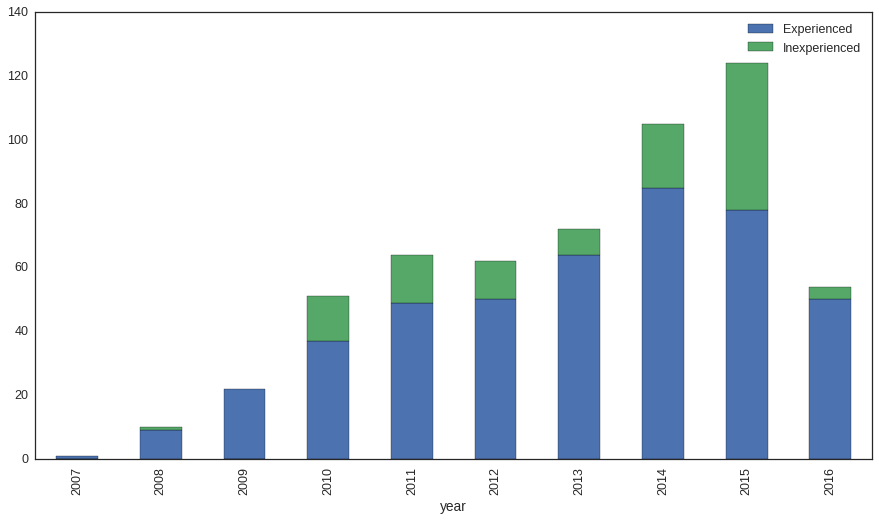

In [110]:
sns.set(font_scale=1.25)
plt.style.use('seaborn-white')
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(15,8), facecolor='w', edgecolor='k')

threshold = 7

compare_gt_10 = compare_overtime_df.query("active_days_to_date>={0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})
compare_lt_10 = compare_overtime_df.query("active_days_to_date<{0}".format(threshold)).groupby('year').aggregate({'uid':pd.Series.nunique})

compare_gt_10.columns = ['Experienced']
compare_lt_10.columns = ['Inexperienced']

compare_gt_10.join(lt_10).plot(ax=axs,kind='bar',stacked=True)